In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import tensorflow as tf

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from network import Model

from scipy.stats import pearsonr
import json
from tools_lnd import rule_set_names, remove_ax_lines, remove_spines, remove_ticks

In [2]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v5_figs','paper_figs','rev','no_of_clusters')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [282]:
##################################################################
#Find right model dir
##################################################################
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
method = 'ward'
max_d = 3.5
sparsity_threshold = .15
ex_1 = 1
ex_2 = 6
ex_3 = 8
al = .3
seed_set = [str(0),str(1),str(2)]#[str(0),str(1)]

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_trains_str = '_'.join(rule_trains)

n_tasks = str(len(rule_trains))
n_rnn = 128
l2w = -6
l2h = -6
l1w = 0
l1h = 0
seed = 1
lr = -6
sigma_rec = 1/20
sigma_x = 2/20
pop_rule = 5
ruleset = 'all'
w_rec_coeff  = 8/10
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
data_folder_all = 'data/rnn/multitask/stepnet/'

# identify master network to compare other networks to. can be chosen randomly
rnn_type_master = 'LeakyRNN'
activation_master = 'softplus'
w_init_master = 'diag'
label_master = ' '.join([rnn_type_master,activation_master,w_init_master])
seed_master = str(1)
# m_master = os.path.join(p,data_folder_all,'final1',rnn_type_master,activation_master,w_init_master,
#                         n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed_master)

net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)

net_name2 = '_sig_rec'+str(sigma_rec)+'_sig_x'+str(sigma_x)+'_w_rec_coeff'+"{:.1f}".format(w_rec_coeff)+'_'+rule_trains_str

m_master = os.path.join(p,'data','rnn','multitask',net,'final1',ruleset,rnn_type_master,activation_master,
    w_init_master,str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name+net_name2,str(seed))

# lesion_folder = 'lesion_fps_hierarchical_'+method+'_'+'distance'+'_max_d'+str(max_d)
method = 'ward'
criterion = 'distance'
cel_max_d = '3.5'

lesion_folder = 'lesion_fps_hierarchical_ward_maxclust_opt_clust'
# lesion_folder = 'lesion_fps_hierarchical_ward_distance_opt_clust'
# lesion_folder = 'lesion_fps_hierarchical_'+method+'_'+criterion+'_max_d'+str(cel_max_d)
save_dir = os.path.join(m_master,lesion_folder)
cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
feature_names_master = cluster_var['tick_names']

# set of networks to compare
rnn_type_set = ['LeakyRNN','LeakyGRU']
activation_set = ['retanh','tanh','softplus']
w_init_set = ['diag','randgauss']
data_folder_set = ['final1','untrained']
color_set = {}
color_set['final1'] = 'k'
color_set['untrained'] = 'dodgerblue'
color_set['no_noise'] = 'orangered'
data_folder = 'final1'
l2w = -6
l2h = -6

task_cluster_number = np.empty((len(rnn_type_set),len(activation_set),len(w_init_set),len(seed_set)),dtype=float)
unit_cluster_number = np.empty((len(rnn_type_set),len(activation_set),len(w_init_set),len(seed_set)),dtype=float)

for rnn_type_i in range(len(rnn_type_set)):
    
    rnn_type = rnn_type_set[rnn_type_i]
    
    for activation_i in range(len(activation_set)):
        
        activation = activation_set[activation_i]
        
        for w_init_i in range(len(w_init_set)):
            
            w_init = w_init_set[w_init_i]

            for seed in seed_set:

                if (rnn_type == 'LeakyRNN') & (activation == 'tanh') & (data_folder == 'final1'):
                    w_rec_coeff  = 1
                    lr = -8
                else:
                    w_rec_coeff  = 8/10
                    lr = -6

                net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)

                net_name2 = '_sig_rec'+str(sigma_rec)+'_sig_x'+str(sigma_x)+'_w_rec_coeff'+"{:.1f}".format(w_rec_coeff)+'_'+rule_trains_str

                m = os.path.join(p,'data','rnn','multitask',net,data_folder,ruleset,
                                        rnn_type,activation,w_init,str(len(rule_trains))+'_tasks',
                                        str(n_rnn)+'_n_rnn',net_name+net_name2,str(seed))

                #load atlas data
                save_dir = os.path.join(m,lesion_folder)
                cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
                D = cluster_var['D'].T
                feature_names_original = [cluster_var['tick_names'][s] for s in 
                                          range(len(cluster_var['tick_names']))]

                feat_order = [feature_names_original.index(s) for i,s in enumerate(feature_names_master)]
                X = D[:,feat_order]
                Y = sch.linkage(X.T, method=method)
                clusters_top = fcluster(Y, thresh, criterion=criterion)

                unit_cluster_number[rnn_type_i,activation_i,w_init_i,int(seed)] = max(cluster_var['clusters'])
                task_cluster_number[rnn_type_i,activation_i,w_init_i,int(seed)] = max(clusters_top)
                
                    

In [283]:
m

'/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final1/all/LeakyGRU/softplus/randgauss/15_tasks/128_n_rnn/lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2'

In [272]:
max_clust_unit = max(unit_cluster_number.flatten())
max_clust_task_period = max(task_cluster_number.flatten())

Text(0.5,0,'Number of clusters')

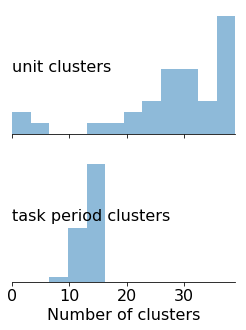

In [273]:
num_var = len(activation_set)
fig = plt.figure(figsize=(4,5))         
    
ax = plt.subplot(2,1,1)
plt.hist(unit_cluster_number.flatten(),alpha = .5, bins = 12, range = [0,max_clust_unit])
plt.text(0,.5*ax.get_ylim()[1],'unit clusters')

ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim([0,max_clust_unit])
ax.tick_params(axis='x',label1On=False)

ax = plt.subplot(2,1,2)
plt.hist(task_cluster_number.flatten(),alpha = .5, bins = 12, range = [0,max_clust_unit])
plt.text(0,.5*ax.get_ylim()[1],'task period clusters')

ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim([0,max_clust_unit])
ax.set_xlabel('Number of clusters')


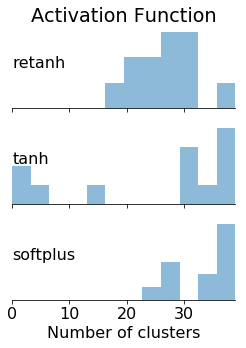

In [274]:
num_var = len(activation_set)
fig = plt.figure(figsize=(4,5))         
    
for act_fxn in range(num_var):
    ax = plt.subplot(num_var,1,act_fxn+1)
    plt.hist(unit_cluster_number[:,act_fxn,:,:].flatten(),alpha = .5, bins = 12, range = [0,max_clust_unit])
    
    activation = activation_set[act_fxn]
    plt.text(0,.5*ax.get_ylim()[1],activation)
    
    ax.set_yticks([])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlim([0,max_clust_unit])
    
    if act_fxn<num_var-1:
        ax.tick_params(axis='x',label1On=False)
    else:
        ax.set_xlabel('Number of clusters')
       
    if act_fxn==0:
        plt.title('Activation Function')

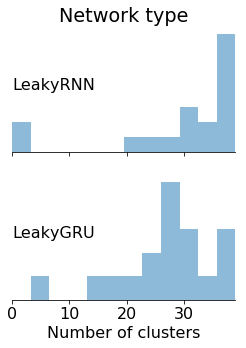

In [275]:
num_var = len(rnn_type_set)
fig = plt.figure(figsize=(4,5))   
                
    
for rnn_type in range(num_var):
    ax = plt.subplot(num_var,1,rnn_type+1)
    plt.hist(unit_cluster_number[rnn_type,:,:,:].flatten(),alpha = .5, bins = 12, range = [0,max_clust_unit])
    
    rnn_type_name = rnn_type_set[rnn_type]
    plt.text(0,.5*ax.get_ylim()[1],rnn_type_name)
    
    ax.set_yticks([])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlim([0,max_clust_unit])
    
    if rnn_type<num_var-1:
        ax.tick_params(axis='x',label1On=False)
    else:
        ax.set_xlabel('Number of clusters')
       
    if rnn_type==0:
        plt.title('Network type')

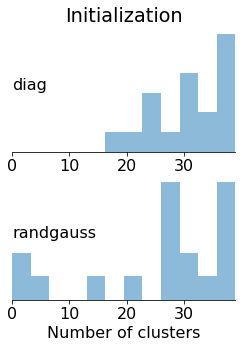

In [276]:
num_var = len(w_init_set)
fig = plt.figure(figsize=(4,5))   
                
    
for init_type in range(num_var):
    ax = plt.subplot(num_var,1,init_type+1)
    plt.hist(unit_cluster_number[:,:,init_type,:].flatten(),alpha = .5, bins = 12, range = [0,max_clust_unit])
    
    init_name = w_init_set[init_type]
    plt.text(0,.5*ax.get_ylim()[1],init_name)
    
    ax.set_yticks([])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlim([0,max_clust_unit])
    
    if rnn_type<num_var-1:
        ax.tick_params(axis='x',label1On=False)
    else:
        ax.set_xlabel('Number of clusters')
       
    if init_type==0:
        plt.title('Initialization')

(1, 2, 1, 2)

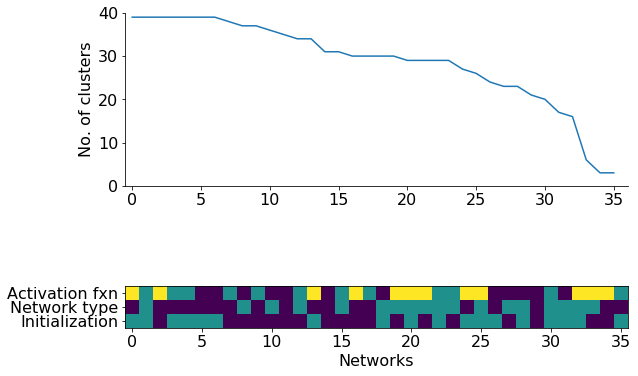

In [280]:
x = unit_cluster_number
n_networks = len(x.flatten())

fig = plt.figure(figsize=(9,7)) 
ax = plt.subplot(2,1,1)
plt.plot(x.flatten()[np.argsort(-x.flatten())])
ax.set_ylabel('No. of clusters')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([0,max_clust_unit+1])
ax.set_xlim([-.5,n_networks])

ax = plt.subplot(2,1,2)
XX,YY,ZZ,AA = np.meshgrid(np.arange(x.shape[3]),np.arange(x.shape[2]),np.arange(x.shape[1]),np.arange(x.shape[0]))
table = np.vstack((x.ravel(),XX.ravel(),ZZ.ravel(),YY.ravel(),AA.ravel())).T
plt.imshow(table[np.argsort(-x.flatten()),:][:,2:].T)

ax.set_yticks((0,1,2))
ax.set_yticklabels(['Activation fxn','Network type','Initialization'])
ax.set_xlim([-.5,n_networks-.5])
ax.set_xlabel('Networks')

rnn_type_i,activation_i,w_init_i,int(seed)